## 設定

In [71]:
import numpy as np
import pandas as pd
import six
import quandl as ql
import pandas as pd
import datetime

import chainer
# from chainer import computational_graph  # need GraphViz
# from chainer import cuda  # For GPU
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer import serializers


In [40]:
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# Quandle用API Key の設定
ql.ApiConfig.api_key = 'CbzNMfBFSFEFsiNNAe97' # APIKeyを置かないと取得制限

## データの取得
目的変数　：　USD/JPY

説明変数　：　USD/JPY（１〜30日前）、日経平均、S&P株価、日本GDP、米国GDP、日本国債金利(10年)、米国国債金利(10年)

In [49]:
# USD/JPY
df_USD_JPY = ql.get('FRED/DEXJPUS')
df_USD_JPY.rename(columns={"VALUE":"USD/JPY"},inplace=True)
df_USD_JPY.tail(5)

,USD/JPY
DATE,
2016-06-20,104.32
2016-06-21,104.56
2016-06-22,104.56
2016-06-23,105.90
2016-06-24,102.26


In [72]:
# 1日づつずらして説明変数を作成
for in range(1:30)
    df_USD_JPY_1 = df_USD_JPY.ix[i:(len(df_USD_JPY)-i),]
    df_USD_JPY_1.index + datetime.timedelta(days=i)

DatetimeIndex(['1971-01-06', '1971-01-07', '1971-01-08', '1971-01-09',
               '1971-01-12', '1971-01-13', '1971-01-14', '1971-01-15',
               '1971-01-16', '1971-01-19',
               ...
               '2016-06-11', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-18', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='DATE', length=11408, freq=None)

In [50]:
# 目的変数（USD/JPY）のデータが存在する日付を取得
df_USD_JPY.index

DatetimeIndex(['1971-01-04', '1971-01-05', '1971-01-06', '1971-01-07',
               '1971-01-08', '1971-01-11', '1971-01-12', '1971-01-13',
               '1971-01-14', '1971-01-15',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='DATE', length=11410, freq=None)

In [42]:
# 日経平均株価、S&P株価
df_STOCK = ql.get(['NIKKEI/INDEX', 'YAHOO/INDEX_GSPC']) 
df_STOCK = df_STOCK.ix[:,df_STOCK.columns.isin(["NIKKEI/INDEX - Close Price","YAHOO/INDEX_GSPC - Close"])]
df_STOCK.rename(columns={"NIKKEI/INDEX - Close Price":"NIKKEI", "YAHOO/INDEX_GSPC - Close": "SP500"},inplace=True)
df_STOCK.tail(5)

,NIKKEI,SP500
Date,,
2016-06-28,15323.14,2036.089966
2016-06-29,15566.83,2070.770020
2016-06-30,15575.92,2098.860107
2016-07-01,15682.48,2102.949951
2016-07-04,15775.80,NaN


In [43]:
# 日本GDP
df_GDP_JP = ql.get('ODA/JPN_NGDP_R')
df_GDP_JP.rename(columns={"Value":"GDP_JP"},inplace=True)
df_GDP_JP.tail(5)

,GDP_JP
Date,
2017-12-31,530842.754
2018-12-31,532773.000
2019-12-31,536478.458
2020-12-31,540236.014
2021-12-31,543790.697


In [51]:
df_GDP_JP.head(10)

,GDP_JP
Date,
1980-12-31,269833.875
1981-12-31,281104.415
1982-12-31,290596.210
1983-12-31,299490.599
1984-12-31,312859.557
1985-12-31,332674.069
1986-12-31,342092.327
1987-12-31,356143.520
1988-12-31,381596.006


In [44]:
# 米国GDP
df_GDP_US = ql.get('FRED/GDP')
df_GDP_US.rename(columns={"VALUE":"GDP_US"},inplace=True)
df_GDP_US.tail(5)

,GDP_US
DATE,
2015-01-01,17649.3
2015-04-01,17913.7
2015-07-01,18060.2
2015-10-01,18164.8
2016-01-01,18230.1


In [53]:
# 日本国債金利(10年)
df_Interest_JP = ql.get('MOFJ/INTEREST_RATE_JAPAN_10Y')
df_Interest_JP.rename(columns={"Value":"Interest_JP"},inplace=True)
df_Interest_JP.tail(10)

,Interest_JP
Date,
2016-06-21,-0.146
2016-06-22,-0.150
2016-06-23,-0.146
2016-06-24,-0.201
2016-06-27,-0.202
2016-06-28,-0.233
2016-06-29,-0.242
2016-06-30,-0.237
2016-07-01,-0.262


In [46]:
# 米国国債金利(10年)
df_Interest_US = ql.get('FRED/DGS10')
df_Interest_US.rename(columns={"VALUE":"Interest_US"},inplace=True)
df_Interest_US.tail(5)

,Interest_US
DATE,
2016-06-23,1.74
2016-06-24,1.57
2016-06-27,1.46
2016-06-28,1.46
2016-06-29,1.50


In [55]:
# データをmerge"
#df_merge = pd.concat([df_STOCK, df_Interest_JP, df_Interest_US, df_GDP_JP, df_GDP_US, df_USD_JPY], axis=1,join="inner")
df_merge = pd.concat([df_STOCK, df_Interest_JP, df_Interest_US, df_USD_JPY], axis=1,join="inner")
df_merge.tail(10)

,NIKKEI,SP500,Interest_JP,Interest_US,USD/JPY
2016-06-13,16019.18,2079.060059,-0.167,1.62,106.07
2016-06-14,15859.00,2075.320068,-0.172,1.62,106.02
2016-06-15,15919.58,2071.500000,-0.197,1.60,105.87
2016-06-16,15434.14,2077.989990,-0.208,1.57,104.05
2016-06-17,15599.66,2071.219971,-0.157,1.62,104.20
2016-06-20,15965.30,2083.250000,-0.151,1.67,104.32
2016-06-21,16169.11,2088.899902,-0.146,1.71,104.56
2016-06-22,16065.72,2085.449951,-0.150,1.69,104.56
2016-06-23,16238.35,2113.320068,-0.146,1.74,105.90
2016-06-24,14952.02,2037.300049,-0.201,1.57,102.26


In [73]:
# データの並びをシャッフル
calcData = df_merge.reindex(np.random.permutation(df_merge.index))
calcData.head(5)

,NIKKEI,SP500,Interest_JP,Interest_US,USD/JPY
2009-10-27,10212.46,1063.410034,1.406,3.49,92.04
1990-06-27,32312.75,355.140015,6.570,8.52,154.38
1994-04-12,19648.33,447.570007,4.252,6.87,103.62
2011-03-28,9478.53,1310.189941,1.241,3.47,81.67
1995-02-06,18667.23,481.140015,4.616,7.53,99.30


In [7]:
# 入力データと教師データに分割
pd_y = calcData['out']
pd_x = calcData.drop(['out'], axis=1)

# numpy配列にデータフレームから変換
x_array = pd_x.as_matrix()
y_array = pd_y.as_matrix()

In [8]:
# 正規化し,float32の型に変換
x_scale = scale(x_array).astype(np.float32)
y_scale = y_array.astype(np.int32)

# サンプルの一部をテストデータ用に分割
N = 550
x_train, x_test = np.split(x_scale, [N])
y_train, y_test = np.split(y_scale, [N])
N_test = y_test.size

print(u'学習データサンプル数：', N)
print(u'テストデータサンプル数：', N_test)

学習データサンプル数： 550
テストデータサンプル数： 99


## Deep learningのモデル定義

In [9]:
# 4層NN
class ClfyMNN(chainer.Chain):
    def __init__(self, n_in, n_units, n_out, train=True):
        super(ClfyMNN, self).__init__(
            l1=L.Linear(n_in, n_units),
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, n_units),
            l4=L.Linear(n_units, n_out),
        )
        self.train = train
    
    # 全てReLUで実施
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        y = self.l4(h3)
        return y

### バッチサイズや隠れ層のユニット数

In [10]:
batchsize = 100 # 学習時サンプルデータ分割バッチサイズ
n_epoch = 20 # 学習ループ数
n_units = 50 # 隠れ層のユニット数

### 各種設定

In [11]:
n_in = 8 # 入力データの次元
n_out = 3 # 分類だと分類数を定義

model = L.Classifier(ClfyMNN(n_in, n_units, n_out))
# cuda.get_device(0).use() # For GPU
# model.to_gpu() # For GPU
# xp = cuda.cupy # For GPU
xp = np  # For CPU

In [12]:
# 最適化手法の指定
optimizer = optimizers.Adam() # とりあえず無難なAdam
optimizer.setup(model)

## 学習の実施

In [13]:
out_train_accuracy = []
out_test_accuracy = []
out_train_loss = []
out_test_loss = []

print_epoch = 5 # 途中経過出力タイミング

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    if epoch % print_epoch == 0:
        print('epoch', epoch)
        
    # training step
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0

    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        t = chainer.Variable(xp.asarray(y_train[perm[i:i + batchsize]]))
        
        # Pass loss function
        optimizer.update(model, x, t)
        
        # モデルのグラフ出力(要GraphViz)
        #if epoch == 1 and i == 0:
        #    with open('graph.dot', 'w') as o:
        #        g = computational_graph.build_computational_graph(
        #            (model.loss, ))
        #        o.write(g.dump())
        #    print('graph generated')
        
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
    
    out_train_accuracy.append(sum_accuracy / N)
    out_train_loss.append(sum_loss / N)
    if epoch % print_epoch == 0:
        print('train mean loss={}, accuracy={}'.format(
            sum_loss / N, sum_accuracy / N))
    
    # Evaluation step
    sum_accuracy = 0
    sum_loss = 0
    for i in six.moves.range(0, N_test, batchsize):
        x = chainer.Variable(xp.asarray(x_test[i:i + batchsize]),
                            volatile='on') # パラメータの更新をさせないようにvolatile='on'に
        t = chainer.Variable(xp.asarray(y_test[i:i + batchsize]),
                            volatile='on')
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    out_test_accuracy.append(sum_accuracy / N_test)
    out_test_loss.append(sum_loss / N_test)
    if epoch % print_epoch == 0:
        print('test mean loss={}, accuracy={}'.format(
            sum_loss / N_test, sum_accuracy / N_test))

epoch 5
train mean loss=1.059808991172097, accuracy=0.42363636602054944
test mean loss=1.1437941789627075, accuracy=0.2929292917251587
epoch 10
train mean loss=1.0227636640722102, accuracy=0.4927272688258778
test mean loss=1.1501272916793823, accuracy=0.3737373650074005
epoch 15
train mean loss=0.9904924793676897, accuracy=0.5363636396147988
test mean loss=1.1627455949783325, accuracy=0.3030303120613098
epoch 20
train mean loss=0.9545178034088828, accuracy=0.5690909136425365
test mean loss=1.1674188375473022, accuracy=0.3636363744735718


## 学習の結果

epochの進捗とそれに合わせた的中率をプロット.

過学習になっていないかtestデータの的中率を見た方が良い.

/Users/YoshinoKazuyoshi/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/YoshinoKazuyoshi/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


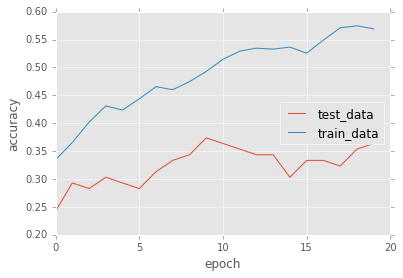

In [14]:
plt.style.use('ggplot') # ggplot風出力

plt.plot(out_test_accuracy, label='test_data')
plt.plot(out_train_accuracy, label='train_data')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 5) # 凡例の場所指定

plt.show()

## モデルの予測値について

In [15]:
# 学習されたパラメータへもう一度テストデータを通す(ここはもっといいやり方ありそう)
out_h1 = F.relu(model.predictor.l1(chainer.Variable(xp.asarray(x_test))))
out_h2 = F.relu(model.predictor.l2(out_h1))
out_h3 = F.relu(model.predictor.l3(out_h2))
estimate_y = model.predictor.l4(out_h3)

In [16]:
#t = cuda.to_cpu(estimate_y.data) # For GPU
t = estimate_y.data # arrayとしてデータを取り出す

# 一番大きいargmentを推定値とする
est = []
for idx in range(N_test):
    est.append(np.argmax(t[idx,:]))
pd_est = pd.DataFrame(est)
pd_est.columns = ['est']
pd_est.head(5)

,est
0,0
1,2
2,1
3,1
4,0


In [17]:
# 元々のデータをくっつけてみる
pd_ans = pd_y.reset_index(drop=True) # シャッフルしてるのでindex振り直しておく
pd_ans.columns = ['ans']

pd_compare = pd.concat([pd_est, pd_ans], axis=1)
pd_compare['compare'] = np.where(pd_compare['est'] == pd_compare['out'], 1, 0) # 当たってたら1、外れてたら0
pd_compare.head(20)

,est,out,compare
0,0.0,2,0
1,2.0,2,1
2,1.0,1,1
3,1.0,1,1
4,0.0,0,1
5,2.0,1,0
6,0.0,2,0
7,0.0,0,1
8,1.0,1,1
9,1.0,0,0


In [18]:
N_match = pd_compare['compare'].sum(axis=0)
Per_match = 100 * N_match / N_test
print(u'的中率：{} %'.format(Per_match))

的中率：34.343434343434346 %
